In [115]:
!pip install torch torchvision matplotlib wandb


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import wandb

# 1. Model Tanımlamaları
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        z = torch.relu(self.fc3(z))
        img = self.tanh(self.fc4(z))
        return img.view(-1, 1, 28, 28)  # Çıkış resim boyutu 28x28

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        img = img.view(-1, 784)  # 28x28 resmin düzleştirilmesi
        x = torch.relu(self.fc1(img))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        validity = self.sigmoid(self.fc4(x))
        return validity


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import wandb

# Hyperparameters
batch_size = 64
epochs = 20
learning_rate = 0.0002
z_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Initialize Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# WandB setup
wandb.init(project="gan-mnist", config={"epochs": epochs, "batch_size": batch_size, "learning_rate": learning_rate})

# TensorBoard setup
writer = SummaryWriter()

# Training Loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()

    total_loss_g = 0
    total_loss_d = 0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Real labels and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator forward pass (real)
        optimizer_d.zero_grad()
        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels)

        # Discriminator forward pass (fake)
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach())  # Detach to avoid updating the generator
        d_loss_fake = criterion(fake_output, fake_labels)

        # Backprop and optimize discriminator
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_d.step()

        # Generator forward pass (train with discriminator's feedback)
        optimizer_g.zero_grad()
        output = discriminator(fake_imgs)
        g_loss = criterion(output, real_labels)  # We want the generator to fool the discriminator
        g_loss.backward()
        optimizer_g.step()

        # Accumulate losses
        total_loss_g += g_loss.item()
        total_loss_d += d_loss.item()

    # Log and save model periodically
    avg_g_loss = total_loss_g / len(train_loader)
    avg_d_loss = total_loss_d / len(train_loader)
    wandb.log({"epoch": epoch + 1, "D_loss": avg_d_loss, "G_loss": avg_g_loss})

    # Output loss at every epoch
    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")

    # Save model checkpoints
    if (epoch + 1) % 10 == 0:
        torch.save(generator.state_dict(), f"generator_epoch_{epoch + 1}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch + 1}.pth")

# Save the final model
torch.save(generator.state_dict(), "generator_final.pth")
torch.save(discriminator.state_dict(), "discriminator_final.pth")
wandb.finish()


Epoch [1/20] | D Loss: 0.3635 | G Loss: 2.9099
Epoch [2/20] | D Loss: 0.1598 | G Loss: 5.1304
Epoch [3/20] | D Loss: 0.1321 | G Loss: 4.9188
Epoch [4/20] | D Loss: 0.1103 | G Loss: 4.4815
Epoch [5/20] | D Loss: 0.0952 | G Loss: 4.6510
Epoch [6/20] | D Loss: 0.1158 | G Loss: 3.7801
Epoch [7/20] | D Loss: 0.0787 | G Loss: 4.8071
Epoch [8/20] | D Loss: 0.1701 | G Loss: 3.0139
Epoch [9/20] | D Loss: 0.2508 | G Loss: 2.4468
Epoch [10/20] | D Loss: 0.3140 | G Loss: 2.0860
Epoch [11/20] | D Loss: 0.3054 | G Loss: 2.1212
Epoch [12/20] | D Loss: 0.3109 | G Loss: 2.0745
Epoch [13/20] | D Loss: 0.3369 | G Loss: 2.0006
Epoch [14/20] | D Loss: 0.3381 | G Loss: 1.9931
Epoch [15/20] | D Loss: 0.3412 | G Loss: 1.9828
Epoch [16/20] | D Loss: 0.3515 | G Loss: 1.9557
Epoch [17/20] | D Loss: 0.3559 | G Loss: 1.9398
Epoch [18/20] | D Loss: 0.3608 | G Loss: 1.8981
Epoch [19/20] | D Loss: 0.3629 | G Loss: 1.9043
Epoch [20/20] | D Loss: 0.3635 | G Loss: 1.8891


D_loss,█▃▂▂▁▂▁▃▅▇▇▇▇▇▇█████
G_loss,▃██▇▇▅▇▃▂▁▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
D_loss,0.36347
G_loss,1.88908
epoch,20


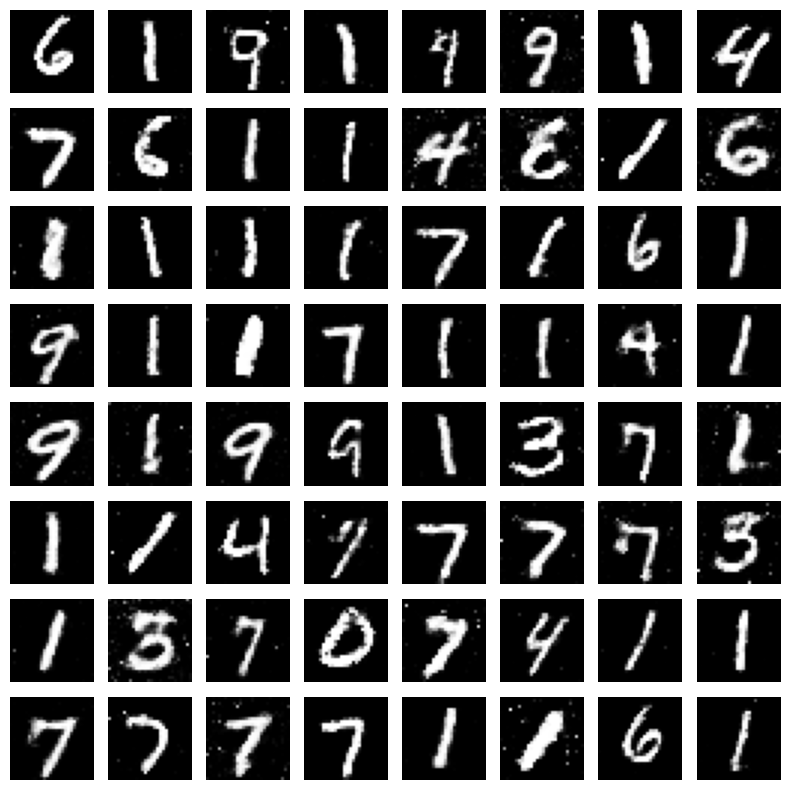

In [117]:
import torch
import matplotlib.pyplot as plt

# Gerekli parametreleri tanımla
# Z_DIM = 100  # Rastgele vektör boyutu - This is already defined globally
# NUM_CLASSES = 10  # 10 farklı sınıf (0-9 arası rakamlar) - Not needed for this simple generator
# IMG_SIZE = 28  # Görsel boyutu (28x28 gibi) - Not needed for this simple generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli yükle
# Use the Generator definition that was trained. It takes no arguments other than self
# and uses the global z_dim.
# Make sure the Generator class from the training cell (ipython-input-53-640fa771e8ae) is executed last among the Generator definitions
# before running this cell, or copy its definition here.
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256), # z_dim is globally defined
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Initialize the generator as defined and trained
generator = Generator().to(device)

# Check if the checkpoint file exists before loading
import os
checkpoint_path = "generator_epoch_60.pth" # Check if the training loop saved to the current directory
# Or if you saved to a specific directory:
# checkpoint_path = "checkpoints/generator_epoch_60.pth"

if os.path.exists(checkpoint_path):
    # Modeli yükle
    generator.load_state_dict(torch.load(checkpoint_path))
else:
    print(f"Checkpoint file not found: {checkpoint_path}")
    # You might want to exit or handle this case differently
    # For now, we'll continue with the initialized model (which won't be trained)

# Modeli değerlendirme moduna al
generator.eval()

# Rastgele z ile örnek üret (labels are not used by this generator)
z = torch.randn(64, z_dim).to(device)  # Batch size = 64, z boyutu = z_dim

# Modelden örnek görseller üret
with torch.no_grad():
    generated_images = generator(z)

# Görselleri görselleştir
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
axes = axes.flatten()

for i in range(64):
    ax = axes[i]
    # Clamp the image values to the valid range [0, 1] after normalization
    img = generated_images[i].cpu().detach().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5 # Denormalize from [-1, 1] to [0, 1]
    img = img.clip(0, 1) # Clamp values

    ax.imshow(img.squeeze(), cmap='gray') # Use squeeze for single channel images
    ax.axis('off')

plt.tight_layout()
plt.show()

# The evaluation part using test_loader and calculating accuracy is for classifiers,
